#  Learning Slowdown Problem

Queremos diseñar un expermineto en el que podamos visualizar el problema del problema de learning slowdown. Para ello usamos el tutorial de Tensorflow para reconocer la base de datos MNIST con dígitos escritos a mano. 

El tutorial lo podemos encontrar en la siguiente dirección:

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network_raw.ipynb

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [24]:
import pandas as pd

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

Vamos a tomar el ejemplo de una red neuronal con 256 neuronas y dos hidden layers. Asimismo, para ilustrar el problema del learning slowdown, medimos los parametros que arroja la función de costo y la precísión del modelo en un espacio de 1000 iteraciones

In [14]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [16]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [4]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [18]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [19]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    step_m1=[]
    loss_m1=[]
    accuracy_m1=[]
    

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            
            step_m1.append(step)
            loss_m1.append(loss)
            accuracy_m1.append(acc)

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images,
                                      Y: mnist.test.labels}))

Step 1, Minibatch Loss= 15280.1768, Training Accuracy= 0.234
Step 100, Minibatch Loss= 699.5206, Training Accuracy= 0.875
Step 200, Minibatch Loss= 219.8902, Training Accuracy= 0.844
Step 300, Minibatch Loss= 154.4981, Training Accuracy= 0.867
Step 400, Minibatch Loss= 73.9870, Training Accuracy= 0.891
Step 500, Minibatch Loss= 53.4589, Training Accuracy= 0.875
Step 600, Minibatch Loss= 27.1234, Training Accuracy= 0.914
Step 700, Minibatch Loss= 47.7699, Training Accuracy= 0.867
Step 800, Minibatch Loss= 25.2369, Training Accuracy= 0.906
Step 900, Minibatch Loss= 39.0427, Training Accuracy= 0.875
Step 1000, Minibatch Loss= 46.1491, Training Accuracy= 0.867
Optimization Finished!
Testing Accuracy: 0.8636


In [30]:
res_m1=pd.DataFrame(step_m1, columns=['step'])
res_m1['loss']=loss_m1
res_m1['acc']=accuracy_m1

In [31]:
res_m1

,step,loss,acc
0,1,15280.176758,0.234375
1,100,699.520569,0.875000
2,200,219.890167,0.843750
3,300,154.498138,0.867188
4,400,73.987022,0.890625
5,500,53.458866,0.875000
6,600,27.123432,0.914062
7,700,47.769947,0.867188
8,800,25.236885,0.906250
9,900,39.042709,0.875000


En ambos casos, podemos observar cómo desde las primeras iteraciones la pérdida del modelo se reduce y la precisión aumenta.

En el caso del costo, los valores se mantienen en el mismo nivel dese aproximadamente la iteración 400. Por otro lado, la precisión del modelo no cambia desde la iteración 100 y en algunos casos incluso disminuye

Text(0.5,1,'Funcion de Costo')

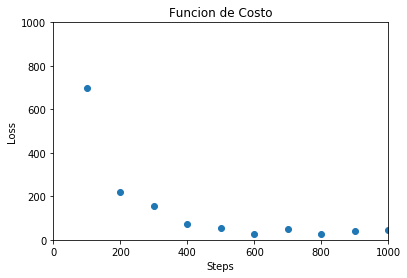

In [47]:
plt.scatter(res_m1['step'], res_m1['loss'])
plt.axis([0,1000,0,1000])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Funcion de Costo')

Text(0.5,1,'Precisión del Modelo')

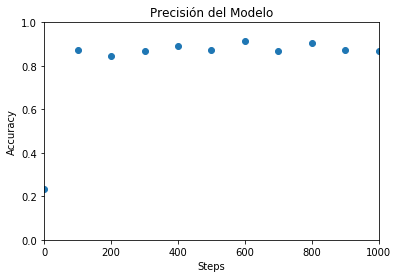

In [49]:
plt.scatter(res_m1['step'], res_m1['acc'])
plt.axis([0,1000,0,1])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Precisión del Modelo')

Text(0.5,1,'Precisión del Modelo')

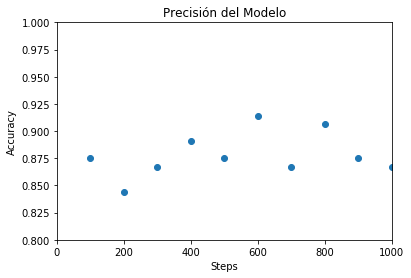

In [50]:
plt.scatter(res_m1['step'], res_m1['acc'])
plt.axis([0,1000,0.8,1])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Precisión del Modelo')